In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.stats as si

In [2]:
df = yf.download("BTC", start="2021-01-01", end="2021-12-30")

[*********************100%***********************]  1 of 1 completed


In [3]:
df.shape[0]

251

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,100.160004,100.160004,100.154999,100.154999,100.154999,102
2021-01-04,100.122902,100.122902,100.122902,100.122902,100.122902,2
2021-01-05,100.059998,100.079903,100.050003,100.050003,100.050003,751
2021-01-06,99.859001,99.874603,99.859001,99.874603,99.874603,109
2021-01-07,99.830002,99.830002,99.785004,99.813698,99.813698,2099


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,99.135735,99.150371,99.112634,99.131618,99.131618,2831.828685
std,0.472000,0.470171,0.461912,0.457527,0.457527,23905.673822
min,98.172501,98.172501,98.172501,98.172501,98.172501,0.000000
25%,98.730003,98.735497,98.722202,98.723003,98.723003,2.000000
50%,99.110001,99.110001,99.110001,99.110001,99.110001,100.000000
75%,99.575497,99.585701,99.559250,99.581249,99.581249,751.500000
max,100.889999,100.889999,100.154999,100.154999,100.154999,354054.000000


# This is how volatile the market was for BTC across the whole year

In [6]:
df['Log Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
vol = np.sqrt(365) * df['Log Return'].std()
print("Volatility After 365 days:", round(vol* 100, 2), '%')

Volatility After 365 days: 2.11 %


# This plot shows the change in prices of Bitcoin during 2021

The data for the period between 5-2021 to 7-2021 seems to be missing

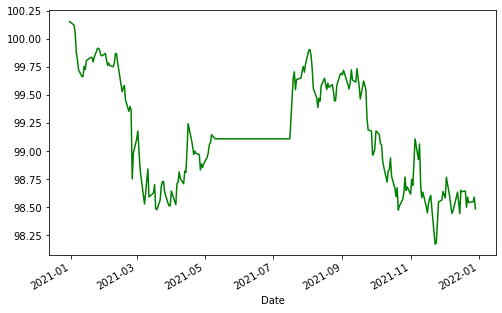

In [7]:
df['Adj Close'].plot(subplots=True, color='green', figsize=(8,5));

Creating the function for call values

In [8]:
def black_scholes_call(s, k, t, r, q, vol):
    #s: spot price
    #k: strike price
    #t: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    d1 = (np.log(s / k) + (r - q + 0.5 * vol**2) * t) / (vol * np.sqrt(t))
    d2 = (np.log(s / k) + (r - q - 0.5* vol**2) * t) / (vol * np.sqrt(t))
    return s * np.exp(-q * t ) * si.norm.cdf(d1, 0.0, 1.0) - k * np.exp(-r * t) * si.norm.cdf(d2, 0.0, 1.0)

Calculating the values for the puts

In [9]:
def black_scholes_put(s, k, t, r, q, vol):
    #s: spot price
    #k: strike price
    #t: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    d1 = (np.log(s / k) + (r - q + 0.5 * vol**2) * t) / (vol * np.sqrt(t))
    d2 = (np.log(s / k) + (r - q - 0.5* vol**2) * t) / (vol * np.sqrt(t))
    return - s * np.exp(-q * t ) * si.norm.cdf(-d1, 0.0, 1.0) - k * np.exp(-r * t) * si.norm.cdf(-d2, 0.0, 1.0)

In [10]:
# values for x-axis
s = np.linspace(50,150,11) 

call = np.zeros((len(s), 1))
put = np.zeros((len(s), 1))
for i in range(len(s)):
    call [i] = black_scholes_call(s[i], 100, 10.0/12.0, 0.06, 0.03, 0.0175)
    put [i] = black_scholes_put(s[i], 100, 10.0/12.0, 0.06, 0.03, 0.0175)

In [11]:
k = 100
r = 0.1
t = 1
q = 0.3

s = np.linspace(50,150,11)
call = np.zeros((len(s), 1))
put = np.zeros((len(s), 1))
for i in range(len(s)):
    s = np.linspace(50,150,11)
    call[i] = black_scholes_call(s[i], k, t, r, q, round(vol* 100, 2)) 
    put [i] = black_scholes_put(s[i], k, t, r, q, round(vol* 100, 2))

In [12]:
call

array([[20.96639822],
       [26.52612111],
       [32.26746174],
       [38.15589001],
       [44.1663583 ],
       [50.280014  ],
       [56.48225112],
       [62.76148702],
       [69.1083585 ],
       [75.51517348],
       [81.9755253 ]])

In [13]:
put

array([[-93.95119979],
       [-93.57122832],
       [-93.13255963],
       [-92.65668347],
       [-92.15733539],
       [-91.64364733],
       [-91.12187046],
       [-90.59637789],
       [-90.0702778 ],
       [-89.54580344],
       [-89.02456964]])

# European Options Plot

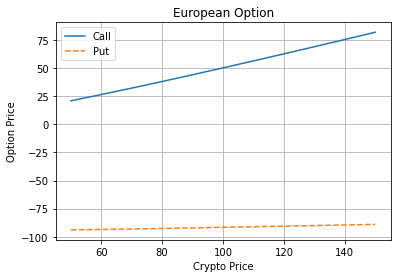

In [14]:
fig = plt.figure()
plt.plot(s, call, '-')
plt.plot(s, put, '--')
plt.grid()
plt.xlabel('Crypto Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Call', 'Put']);

In [17]:
n = 3
s = np.linspace(50,150,11)
r = 0.06
k = 1
v = vol
q = 0.03
t = 10.0 / 12.0

In [15]:
def Binomial_call(n, s, k, r, v, t):
    #s: spot price
    #k: strike price
    #t: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    at = t/n
    u = np.exp(v * np.sqrt(at))
    d = 1. / u
    p = (np.exp(r*at)- d) / (u-d)
    
    stock_value = np.zeros((n+1,n+1))
    stock_value[0,0] = s
    for i in range(1,n+1):
        stock_value[i,0] = stock_value[i-1,0] * u
        for j in range(1,i+1):
            stock_value[i,j] = stock_value[i-1, j-1] * d
    
    
    option_value = np.zeros((n+1, n+1))
    for j in range(1,n+1):
        option_value[n,j] = max(0, stock_value[n,j] - k)
        
    for i in range(n-1, -1,-1):
        for j in range(i+1):
            option_value[i,j] = max(0, stock_value[i,j] - k, np.exp(-r * at) * (p * option_value[i+1 , j] + (1-p) * option_value[i+1, j+1]))
    return option_value[0,0]
            

In [16]:
def Binomial_put(n, s, k, r, v, t):
    #s: spot price
    #k: strike price
    #t: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    at = t/n
    u = np.exp(v * np.sqrt(at))
    d = 1. / u
    p = (np.exp(r*at)- d) / (u-d)
    
    stock_value = np.zeros((n+1,n+1))
    stock_value[0,0] = s
    for i in range(1,n+1):
        stock_value[i,0] = stock_value[i-1,0] * u
        for j in range(1,i+1):
            stock_value[i,j] = stock_value[i-1, j-1] * d
    
    
    option_value = np.zeros((n+1, n+1))
    for j in range(1,n+1):
         option_value[n,j] = max(0,k - stock_value[n,j])
        
    for i in range(n-1, -1,-1):
        for j in range(i+1):
            option_value[i,j] = max(0, k - stock_value[i,j], np.exp(-r*at)*(p*option_value[i+1,j]+(1-p)*option_value[i+1, j+1]))
    
    return option_value[0,0]
            

In [18]:
call2 = np.zeros((len(s), 1))
put2 = np.zeros((len(s), 1))
for i in range(len(s)):
    call[i] = Binomial_call(n, s[i], k, r, v, t)
    put[i] = Binomial_put(n,s[i], k, r, v, t)

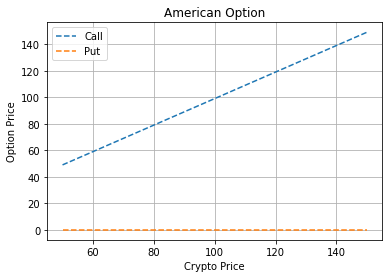

In [19]:
fig = plt.figure()
plt.plot(s, call, '--')
plt.plot(s, put, '--')
plt.grid()
plt.xlabel('Crypto Price')
plt.ylabel('Option Price')
plt.title('American Option')
plt.legend(['Call', 'Put']);

# Calculating Greeks

In [20]:
def delta_call(s, k, t, r, q, vol):
    # delta value for call
    d1 = (np.log(s / k)+ (r - q + 0.5 * vol **2 * t) / (vol * np.sqrt(t)))
    return np.exp(-q * t) * si.norm.cdf(d1, 0.0, 1.0)

In [21]:
def delta_put(s, k, t, r, q, vol):
    #delta value for put
    d1 = (np.log(s / k)+ (r - q + 0.5 * vol **2 * t) / (vol * np.sqrt(t)))

    delta = - np.exp(-q * t) * si.norm.cdf(-d1, 0.0, 1.0)
    return delta

In [37]:
delta_call(s[0], k, t, r, q, vol)

0.9753098913839994

In [38]:
delta_put(s[0], k, t, r, q, vol)

-2.0644333287429384e-08

In [24]:
#Gamma
def gamma(s,k,t,r,q,vol):
    d1 = np.log(s / k) + (r - q + 0.5 * vol ** 2 * t) / (vol * np.sqrt(t))
    gamma = np.exp(-r * t) * si.norm.pdf(d1, 0.0, 1.0) / (vol * s * t)
    return gamma

In [36]:
gamma(s[0], k, t, r, q, vol)

1.2959915323931936e-07

In [26]:
# Rho value for call
def rho_call(s, k , t, r, q, vol):
    d1 = (np.log(s / k) + (r - q + 0.5 * vol ** 2) * t) / (vol * np.sqrt(t))
    d2 =(np.log(s / k) + (r - q - 0.5 * vol ** 2) * t) / (vol * np.sqrt(t))
    rho = k * t * np.exp(-r * t) * si.norm.cdf(d2, 0.0, 1.0)
    return rho

In [27]:
# Rho value for put
def rho_put(s, k , t, r, q, vol):
    d1 = (np.log(s / k) + (r - q + 0.5 * vol ** 2) * t) / (vol * np.sqrt(t))
    d2 =(np.log(s / k) + (r - q - 0.5 * vol ** 2) * t) / (vol * np.sqrt(t))
    rho = - k * t * np.exp( - r * t) * si.norm.cdf(-d2, 0.0, 1.0)
    return rho

In [28]:
rho_call(s[0], k, t, r, q, vol)

0.7926911870839284

In [29]:
rho_put(s[0], k, t, r, q, vol)

-0.0

In [30]:
# Vega
def vega(s,k,t,r,q,vol):
    d1 = np.log( s / k) + (r - q + 0.5 * vol ** 2 * t) / (vol * np.sqrt(t))
    vega = s * np.sqrt(t) * np.exp(-q * t) * si .norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [31]:
vega(s[0], k, t, r, q, vol)

5.326499622869481e-06

In [32]:
# Theta value for call
def theta_call(s, k, t, r, q, vol):    
    d1 = (np.log(s / k) + (r - q + 0.5 * vol ** 2) * t) / (vol * np.sqrt(t))
    d2 = (np.log(s / k) + (r - q - 0.5 * vol ** 2) * t) / (vol * np.sqrt(t))
   
    theta = vol * s * np.exp(-q * t) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(t)) - q * s * np.exp(-q * t) * si.norm.cdf(d1, 0.0, 1.0)
    return theta

In [33]:
# Theta value for put
def theta_put(s, k, t, r, q, vol):
    
    d1 = (np.log(s / k) + (r - q + 0.5 * vol ** 2) * t) / (vol * np.sqrt(t))
    d2 = (np.log(s / k) + (r - q - 0.5 * vol ** 2) * t) / (vol * np.sqrt(t))

    theta = vol * s * np.exp(-q * t) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(t)) - q * s * np.exp(-q * t) * si.norm.cdf(-d1, 0.0, 1.0)
    return theta

In [34]:
theta_call(s[0], k, t, r, q, vol)

-1.462964868042499

In [35]:
theta_put(s[0], k, t, r, q, vol)

0.0